<a href="https://colab.research.google.com/github/Angorith/acorn_python/blob/main/0628_34%EC%9D%BC%EC%B0%A8_%EA%B3%B5%ED%86%B5%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B82%EB%B2%88%2CAI%EB%B3%B5%EC%8A%B5%2C_%EC%8B%9C%EA%B3%84%EC%97%B4_%EC%98%88%EC%B8%A11%EA%B3%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#시간 
#size = 분의 개수
#mean = 평균값
def resample_hour(m_data):
    for key, df in m_data.items():
        df = df.dropna().resample('H').agg({'temp':['size','mean']})    #size, mean = 함수
        df = df.droplevel(level=0, axis=1) #level = 0 은 'temp'
        df.loc[df['size']<48, 'mean'] = np.nan  #size가 48보다 작으면 mean에 결측처리
        df.dropna(inplace=True) #결측 제거
        df = missing_check(df, 'H')
        if 'result' in locals():
            result = pd.concat([result, df])
            continue
        result = df
    return result

dropna() : QC에서 np.nan 삭제

    QC 후, dropna()
    1시간 동안 47개의 분자료
    1시간 동안 60개의 분자료
    01:00 분부터 01:59분까지 자료를 그룹화

    'temp'칼럼에 대해서 size, mean 함수를 수행해라

    'temp' = level 0 다중 컬럼
    'size', 'mean' = level 1 : 'size', 'mean'은 칼럼이름

    'size', 'mean'
    47,      21.8
    60,      22.8
    58,      21.9

Writing timeseries_module.py


TypeError: ignored

In [ ]:
%%writefile timeseries_module.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import glob

def get_filelist(paths):
	file_list = glob.glob(paths+'*')    #모든 파일 불러오기
	hourly_data = []
	every_minute_data = []
	file_list_dict = {}
	for i in file_list:
		if 'TIM' in i:
			hourly_data.append(i)
		else:
			every_minute_data.append(i)
	file_list_dict['TIM'] = hourly_data
	file_list_dict['MI'] = every_minute_data
	return file_list_dict
def get_data(file_list, index_column=2, parse_date=[2]):
	file_list.sort()
	data={}
	for fn in file_list:
		df = pd.read_csv(fn, index_col=index_column, \
			parse_dates=parse_date, encoding='cp949', \
			skiprows=[0], \
			names=['site', 'name', 'time', 'temp'])
		df.drop(['site', 'name'], axis=1, inplace=True)
		data[fn] = df
	return (data)

def missing_check(df, freqs):
	start = df.index[0]
	end = df.index[-1]
	timestamp = pd.date_range(start, end, freq=freqs)
	#print(timestamp)
	df = df.reindex(timestamp)
	return (df)

def physical_check(df):
	df[df<-33.0] = np.nan
	df[df>40] = np.nan
	return (df)

def step_check1(df):
	temp = df.iloc[0, 0]    #diff를 하게 되면 0,0은 NaN이 되기때문에 따로 빼서 저장
	df['step_check'] = df.diff().fillna(-999999.9)
	df[df.step_check<-3.0] = np.nan
	df[df.step_check>3.0] = np.nan
	if temp:
		df.iloc[0, 0] = temp
	return (df)

def persistence_check(df):
	df['persis'] = df.step_check.abs()  #정수 절대값 연산
	dummy_data = df.resample('H').sum()
	dummy_data.drop(dummy_data.index[-1], inplace=True)
	hour = dummy_data[dummy_data.persis<0.1].index.hour
	if len(hour):
		for i in hour:
			df[df.index.hour == i] = np.nan
	return (df)

def keep_data(df, file_name='bird'):
	start = dt.datetime.strftime(df.index[0], '%Y%m%d%H%M%S')
	end = dt.datetime.strftime(df.index[-1], '%Y%m%d%H%M%S')
	if file_name == 'bird':
		file_name = 'OBS_108_AirTemp_'+start+'_'+end+'.csv'
	df.to_csv(file_name)
	return (file_name)

def resample_hour(m_data):
	for key, df in m_data.items():
		df = df.dropna().resample('H').agg({'temp':['size', 'mean']})
		df = df.droplevel(level=0, axis=1)
		df.loc[df['size']<48, 'mean'] = np.nan
		df.dropna(inplace=True)
		df = missing_check(df, 'H')
		if 'result' in locals():
			result = pd.concat([result, df])
			continue
		result=df
	return result

def resample_day(df, col_name='mean'):
	df = df.dropna().resample('D').agg({col_name:['size', 'mean']})
	df = df.droplevel(level=0, axis=1)
	df.loc[df['size']<20, 'mean'] = np.nan
	return (df)

def resample_month(df, col_name='mean'):
	df = df.dropna().resample('M').agg({col_name:['size', 'mean']})
	df = df.droplevel(level=0, axis=1)
	df.loc[df['size']<24, 'mean'] = np.nan
	return (df)

def timeseries_plot(df):
	df.iloc[[11, 20, 21], :] = np.nan
	df.columns=['sizes', 'means']	
	data = df.loc[:'2021-09-01', 'means']
	methods = ['linear', 'quadratic', 'cubic']
	df_gapfilled = pd.DataFrame({m: data.interpolate(method=m) for m in methods})
	df_gapfilled.plot()
	#data.plot()
	plt.grid()
	plt.savefig('gf.png')
	data = data.round(2)
	df_gapfilled = df_gapfilled.round(2)
	data.to_csv('pre_gap_filling.csv')
	df_gapfilled.to_csv('gap_filled.csv')

Overwriting timeseries_module.py


In [ ]:
%%writefile client.py
import timeseries_module as tm

paths = './drive/MyDrive/data/'

file_list_dict = tm.get_filelist(paths)

#print(file_list_dict)

data = tm.get_data(file_list_dict['MI'])

#print(data)

m_data = {}
for key, value in data.items():
	df = tm.missing_check(value, 'T')
	df = tm.physical_check(df)
	df = tm.step_check1(df)
	print(df)
	df = tm.persistence_check(df)
	key_f = tm.keep_data(df)
	m_data[key_f] = df

hourly = tm.resample_hour(m_data)
tm.keep_data(hourly, 'OBS_108_AirTemp_hourly_data') 
diurnal = tm.resample_day(hourly)
tm.keep_data(diurnal, 'OBS_108_AirTemp_diurnal_data')

h_data = tm.get_data(file_list_dict['TIM'])

for i in h_data:
	df = h_data[i]
	df = tm.resample_day(df,'temp') 
	tm.keep_data(df, 'OBS_108_AirTemp_2021_data')

df_month = tm.resample_month(df)
#print(df_month)

tm.timeseries_plot(df)

Writing client.py


In [ ]:
%run client.py

                     temp  step_check
2022-06-01 00:01:00  18.6         NaN
2022-06-01 00:02:00  18.6         0.0
2022-06-01 00:03:00  18.6         0.0
2022-06-01 00:04:00  18.6         0.0
2022-06-01 00:05:00  18.6         0.0
...                   ...         ...
2022-06-01 23:56:00  18.2         0.0
2022-06-01 23:57:00  18.2         0.0
2022-06-01 23:58:00  18.2         0.0
2022-06-01 23:59:00  18.2         0.0
2022-06-02 00:00:00  18.1        -0.1

[1440 rows x 2 columns]
                     temp  step_check
2022-06-02 00:01:00  18.1         NaN
2022-06-02 00:02:00  18.1         0.0
2022-06-02 00:03:00  18.1         0.0
2022-06-02 00:04:00  18.1         0.0
2022-06-02 00:05:00  18.1         0.0
...                   ...         ...
2022-06-02 23:56:00  18.9         0.0
2022-06-02 23:57:00  18.9         0.0
2022-06-02 23:58:00  18.9         0.0
2022-06-02 23:59:00  18.9         0.0
2022-06-03 00:00:00  18.9         0.0

[1440 rows x 2 columns]
                     temp  step_check


In [ ]:
import keras

In [ ]:
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np


# 1. 데이터 셋 생성
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
x_train = x_train.reshape(60000, 784).astype('float32')/ 255.0
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [ ]:
#validation set 준비

x_val = x_train[50000:]
y_val = y_train[50000:]
x_train = x_train[:50000]
y_train = y_train[:50000]

In [ ]:
#train set 고르기
train_rand_idxs = np.random.choice(50000, 700)
val_rand_idxs = np.random.choice(10000, 300)
x_train = x_train[train_rand_idxs]
y_train = y_train[train_rand_idxs]
x_val = x_val[val_rand_idxs]
y_val = y_val[val_rand_idxs]

In [ ]:
#2. 모델 구성하기

model = Sequential()
model.add(Dense(units = 2, input_dim = 28*28, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

#3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [ ]:
class CustomHistory(keras.callbacks.Callback):
    def __init__(self):
        self.loss=[]
        self.val_loss=[]
        self.accuracy = []
        self.val_accuracy = []

    def on_epoch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

In [ ]:
custom_hist = CustomHistory()

In [ ]:
#from keras.callbacks import EarlyStopping
#early_stopping = EarlyStopping(patience=2)
#hist = model.fit(x_train, y_train, epoch=30, batch_size=32, validation= (x_val, y_val), callbacks=[early_stopping])

#다른 얼리 스탑핑
for epoch_idx in range(100):
    print('epochs :' , str(epoch_idx))
    model.fit(x_train, y_train, epochs=1, batch_size = 10, validation_data=(x_val, y_val), callbacks=[custom_hist])

epochs : 0
70/70 [==============================] - 1s 5ms/step - loss: 2.2866 - accuracy: 0.0986 - val_loss: 2.2439 - val_accuracy: 0.1567
epochs : 1
70/70 [==============================] - 0s 3ms/step - loss: 2.2279 - accuracy: 0.1529 - val_loss: 2.1784 - val_accuracy: 0.1767
epochs : 2
70/70 [==============================] - 0s 3ms/step - loss: 2.1786 - accuracy: 0.1671 - val_loss: 2.1273 - val_accuracy: 0.1633
epochs : 3
70/70 [==============================] - 0s 4ms/step - loss: 2.1381 - accuracy: 0.1700 - val_loss: 2.0883 - val_accuracy: 0.1867
epochs : 4
70/70 [==============================] - 0s 4ms/step - loss: 2.0996 - accuracy: 0.1943 - val_loss: 2.0530 - val_accuracy: 0.1967
epochs : 5
70/70 [==============================] - 0s 4ms/step - loss: 2.0607 - accuracy: 0.2043 - val_loss: 2.0194 - val_accuracy: 0.2300
epochs : 6
70/70 [==============================] - 0s 4ms/step - loss: 2.0214 - accuracy: 0.2357 - val_loss: 1.9781 - val_accuracy: 0.2467
epochs : 7
70/70 [==

In [ ]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size =32)
print('## evaluation loss and metrics ##')
print(loss_and_metrics)

313/313 [==============================] - 1s 2ms/step - loss: 1.3763 - accuracy: 0.4932
## evaluation loss and metrics ##
[1.3762996196746826, 0.49320000410079956]


In [ ]:
x_train.shape, y_train.shape

((700, 784), (700, 10))

In [ ]:
x_test.shape, y_test.shape

((10000, 784), (10000, 10))

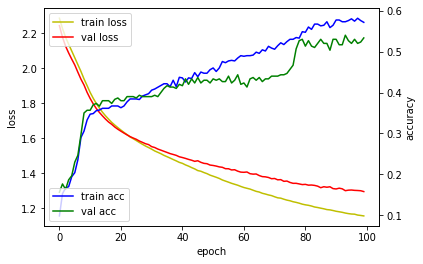

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig , loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(custom_hist.loss, 'y', label = 'train loss')
loss_ax.plot(custom_hist.val_loss, 'r', label='val loss')

acc_ax.plot(custom_hist.accuracy, 'b', label='train acc')
acc_ax.plot(custom_hist.val_accuracy,'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc ='lower left')

plt.show()

# 예측

강수량, 기온, 평균, 증발산량

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv('OBS_ASOS_ANL_20220625151356.csv',skiprows=[0], names=['site','loca','year','airtemp','hpa','rain','hm','rn','ws','evapor'], encoding='cp949')

FileNotFoundError: ignored

In [ ]:
df.head()

In [ ]:
df = df[['airtemp','rain','hm','evapor']]

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.head()

In [ ]:
df.info()

기온 10.4 -> 0~1 사이 값으로 바꿈

AI model에서 계산 -> 예측값을 찾고

예측값이 0.8일 경우 -> 실제기온으로는 얼마인지 알아내기 위해 복원할 수 있게 0~1사이로 고쳐줘야한다.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
signal_data = scaler.fit_transform(df)

X = 기온

X_std = (X - X.min(axis=0)) / (X.max(axis=0)-X.min(axis=0))

X_scaled = X_std * (max - min) +min

In [ ]:
signal_data

In [ ]:
signal_data.shape

시계열을 예측한다는것은 

시계열 데이터 인식하는 딥러닝 모델

- 순환 신경망 recurrent neural network(RNN)

- LSTM long short-term memory 선별 기억 능력을 갖춰 장기 문맥 처리에 유리

In [ ]:
def seq2dataset(seq, window, horizon):
    X=[]
    Y=[]
    for i in range(len(seq)-(window + horizon)+1):
        #print(i)    #0~102
        #print(window)   #3
        idx = i+window
        #print(idx) #3~105
        x=seq[i:idx]
        #print('x :', x.shape)
        y=seq[idx+horizon-1]
        #print('y:' ,y.shape)
        #y = (seq[idx+horizon-1])
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

In [ ]:
X, Y = seq2dataset(signal_data, 3,1)

In [ ]:
X

In [ ]:
X.shape, Y.shape

In [ ]:
Y

In [ ]:
X[0]

In [ ]:
x_train =X[:82]
y_train =Y[:82]
x_test = X[82:]
y_test = Y[82:]

In [ ]:
x_train.shape,y_train.shape ,x_test.shape, y_test.shape

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [ ]:
model = Sequential()
model.add(LSTM(units=128, activation='relu', input_shape=x_train[0].shape))
model.add(Dense(4))
model.compile(loss='mae',optimizer = 'adam', metrics=['accuracy'])